In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ta  # Technical indicators
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# Download the Sentiment Analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\carme\AppData\Roaming\nltk_data...


In [9]:
# Download stock data
stock_symbol = "AAPL"
start_date = "2015-01-01"
end_date = "2025-01-01"

df = yf.download(stock_symbol, start=start_date, end=end_date)

# Ensure 'Close' is 1D
df['Close'] = df['Close'].values.reshape(-1)

# Add technical indicators (Ensuring input is 1D)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'].squeeze()).rsi()
df['MACD'] = ta.trend.MACD(df['Close'].squeeze()).macd()
df['Bollinger_High'] = ta.volatility.BollingerBands(df['Close'].squeeze()).bollinger_hband()
df['Bollinger_Low'] = ta.volatility.BollingerBands(df['Close'].squeeze()).bollinger_lband()

# Fill NaN values
df.fillna(method="bfill", inplace=True)

# Print to check
print(df.head())
print(df.shape)  # Should print (rows, columns) without (x,1) error

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume        RSI  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL              
Date                                                                           
2015-01-02  24.347174  24.817059  23.906238  24.805924  212818400  60.986552   
2015-01-05  23.661274  24.195741  23.474212  24.115571  257142000  60.986552   
2015-01-06  23.663498  23.924050  23.300505  23.725852  263188400  60.986552   
2015-01-07  23.995316  24.095527  23.761486  23.872833  160423600  60.986552   
2015-01-08  24.917265  24.975166  24.206870  24.324899  237458000  60.986552   

Price           MACD Bollinger_High Bollinger_Low  
Ticker                                             
Date                                               
2015-01-02  0.636007      26.199017     23.079454  
2015-01-05  0.636007      26.199017     23.079454  
2015-01-06  0.636007      26.199017     23.079454  
2015-01-07  0.636007      26.199017     23.0794


C:\Users\carme\AppData\Local\Temp\ipykernel_46732\495744259.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


In [13]:
# Function to get stock news (dummy dataset, replace with actual API)
news_data = [
    "Apple launches new iPhone, shares surge!",
    "Market crashes due to recession fears",
    "Investors confident in Apple's growth"
]

# Perform sentiment analysis
def get_sentiment_score(news):
    scores = [sia.polarity_scores(article)["compound"] for article in news]
    return np.mean(scores)

df['Sentiment'] = get_sentiment_score(news_data)
print(df[['Sentiment']].head())

Price      Sentiment
Ticker              
Date                
2015-01-02  0.126333
2015-01-05  0.126333
2015-01-06  0.126333
2015-01-07  0.126333
2015-01-08  0.126333


In [15]:
# Select features
features = ['Close', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'Sentiment']
data = df[features].values  

# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

# Create sequences for LSTM-GRU
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step, 0])  # Predict 'Close' price
    return np.array(X), np.array(y)

# Train-test split
time_step = 60
train_size = int(len(data) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape for LSTM-GRU model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(features))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(features))

In [17]:
# Create LSTM-GRU Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, len(features))),
    Dropout(0.2),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

C:\Users\carme\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0252 - val_loss: 0.0058
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.2138e-04 - val_loss: 0.0027
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 9.6886e-04 - val_loss: 0.0032
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.3510e-04 - val_loss: 9.3275e-04
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 8.0002e-04 - val_loss: 0.0036
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.7219e-04 - val_loss: 0.0014
Epoch 12/100
61/61 ━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


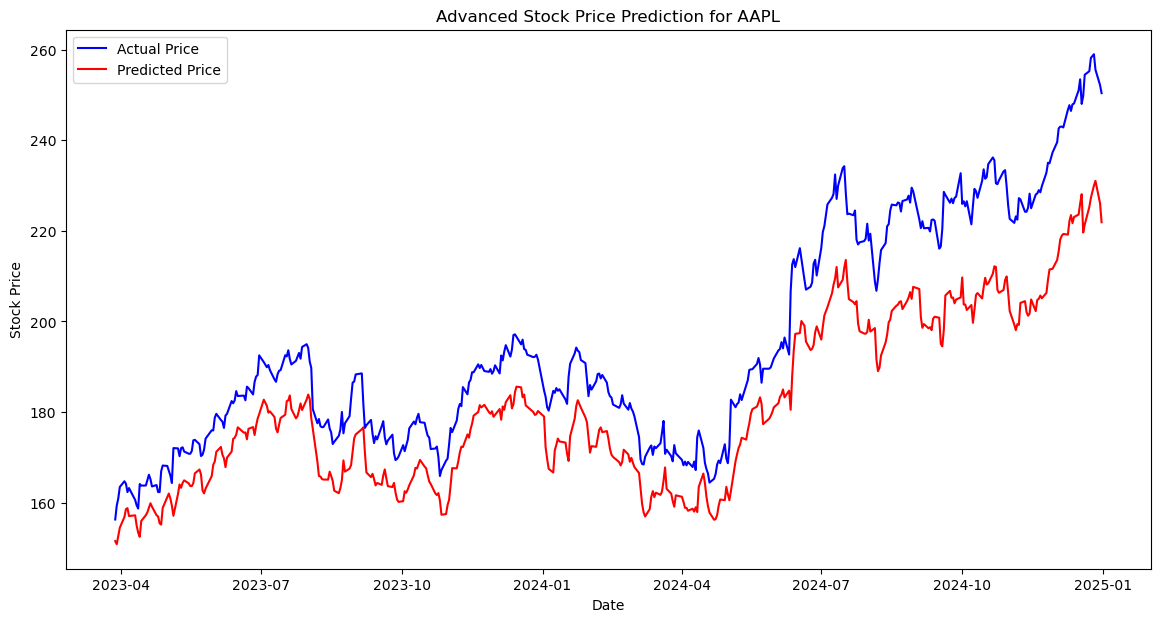

In [19]:
# Predict test data
predictions = model.predict(X_test)

# Convert predictions back to original scale
predictions = scaler.inverse_transform(np.column_stack((predictions, np.zeros((len(predictions), len(features)-1)))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test.reshape(-1,1), np.zeros((len(y_test), len(features)-1)))))[:, 0]

# Plot actual vs predicted prices
plt.figure(figsize=(14,7))
plt.plot(df.index[train_size+time_step:], y_test_actual, label="Actual Price", color="blue")
plt.plot(df.index[train_size+time_step:], predictions, label="Predicted Price", color="red")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f"Advanced Stock Price Prediction for {stock_symbol}")
plt.show()

In [21]:
# Take last 60 days
last_60_days = test_data[-time_step:]

# Reshape for LSTM-GRU model
last_60_days = last_60_days.reshape(1, time_step, len(features))

# Predict future price
future_prediction = model.predict(last_60_days)
future_price = scaler.inverse_transform(np.column_stack((future_prediction, np.zeros((1, len(features)-1)))))[:, 0]

print(f"Predicted Next Day Stock Price for {stock_symbol}: ${future_price[0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Next Day Stock Price for AAPL: $219.91
